In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Animal Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: animals/animals/bison/73b10839bc.jpg  
  inflating: animals/animals/bison/74dc1dd32a.jpg  
  inflating: animals/animals/bison/75ab166a7d.jpg  
  inflating: animals/animals/bison/79e1610d01.jpg  
  inflating: animals/animals/bison/7ba5eee91f.jpg  
  inflating: animals/animals/bison/7d214aab4b.jpg  
  inflating: animals/animals/bison/7f2ef9ab03.jpg  
  inflating: animals/animals/bison/82ec723a4f.jpg  
  inflating: animals/animals/bison/85e145af6c.jpg  
  inflating: animals/animals/bison/862e2c6379.jpg  
  inflating: animals/animals/bison/87a5c700ad.jpg  
  inflating: animals/animals/bison/88b723ce90.jpg  
  inflating: animals/animals/bison/8c3af742c3.jpg  
  inflating: animals/animals/bison/8e34044b98.jpg  
  inflating: animals/animals/bison/8e6adbdc40.jpg  
  inflating: animals/animals/bison/8fce80d5ba.jpg  
  inflating: animals/animals/bison/961a895686.jpg  
  inflating: animals/animals/bison/984a5b583d.jpg  
  inflating: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, precision_score, recall_score
import glob
import torch
from torch import optim
from torch import nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from matplotlib import image as img
import pickle
from scipy import signal
import skimage.measure
from sklearn.model_selection import train_test_split
from numba import cuda
import torchvision # load datasets
from torchvision import datasets, transforms, models
import torch.utils.data as data
from torch.utils.data import Dataset  # Make sure to import Dataset
import os

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the data transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Set the path to your dataset
data_dir = '/content/animals/animals/'

# Create a dataset from the image folders
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Define the ratio for train and test split
train_ratio = 0.8  # 80% of the data for training, 20% for testing

# Calculate the sizes of the train and test sets
num_data = len(dataset)
num_train = int(train_ratio * num_data)
num_test = num_data - num_train

# Split the dataset into train and test sets
train_set, test_set = random_split(dataset, [num_train, num_test])

# Define batch size and create data loaders for train and test sets
batch_size = 16
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Check the length of train and test sets
print(f"Number of training examples: {len(train_set)}")
print(f"Number of testing examples: {len(test_set)}")

# You can now use train_loader and test_loader for training and testing your binary classification model.



Number of training examples: 4320
Number of testing examples: 1080


In [ ]:
classes = ('antelope','badger','bat','bear','bee','beetle','bison','boar','butterfly','cat','caterpillar','chimpanzee','cockroach','cow','coyote','crab','crow','deer','dog','dolphin','donkey','dragonfly','duck','eagle','elephant','flamingo','fly','fox','goat','goldfish','goose','gorilla','grasshopper','hamster','hare','hedgehog','hippopotamus','hornbill','horse','hummingbird','hyena','jellyfish','kangaroo','koala','ladybugs','leopard','lion','lizard','lobster','mosquito','moth','mouse','octopus','okapi','orangutan','otter','owl','ox','oyster','panda','parrot','pelecaniformes','penguin','pig','pigeon','porcupine','possum','raccoon','rat','reindeer','rhinoceros','sandpiper','seahorse','seal','shark','sheep','snake','sparrow','squid','squirrel','starfish','swan','tiger','turkey','turtle','whale','wolf','wombat','woodpecker','zebra')

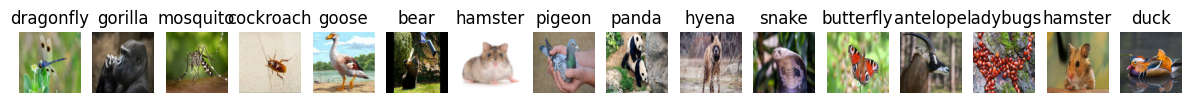

In [ ]:
def show_images_labels(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 8))
    for i in range(len(images)):
        image = images[i].permute(1, 2, 0)  # Convert to (H, W, C) format
        label = classes[labels[i]]
        axes[i].imshow(image)
        axes[i].set_title(label)
        axes[i].axis('off')
    plt.show()

num_images_to_display = 4  # Customize this

# Iterate through the test_loader and display the specified number of images
displayed_images = 0
for batch in test_loader:
    images, labels = batch
    show_images_labels(images, labels)
    displayed_images += len(images)
    if displayed_images >= num_images_to_display:
        break

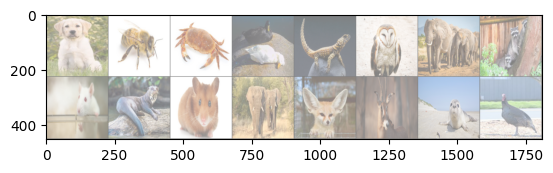

dog   bee   crab  duck  lizard owl   elephant raccoon rat   otter hamster elephant fox   antelope seal  turkey


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.4 MB/s eta 0:00:00


In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
model_name = "google/vit-base-patch16-224-in21k"
num_classes = 90  # Number of classes in your dataset
model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_classes)

# Define the image feature extractor
feature_extractor = ViTFeatureExtractor(model_name)



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)

In [ ]:
def train(net, training_data,epochs,criterion,optimizer,validation):
 train_loss=[]
 train_accuracy=[]
 val_acc=[]
 val_loss=[]
 for epoch in range(epochs):
    loss_=0
    correct=0
    total=0
    for batch, (data, target) in enumerate(training_data):
        data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        out = net(data).logits
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        loss_+=loss.item()
        predicted = torch.max(out.data, 1)[1]
        total += target.size(0)
        correct += (predicted ==target).sum()

    train_loss.append(loss_/len(training_data))
    train_accuracy.append(correct / float(total))
    print('Train Epoch: {} \tLoss: {}\tAccuracy: {}'.format( epoch, loss.item(),100*(correct / float(total))))

 return train_loss,train_accuracy ,val_loss,val_acc

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion=nn.CrossEntropyLoss()
train_loss,train_accuracy,val_loss,val_acc=train(model,train_loader,7,criterion,optimizer,True)

Train Epoch: 0 	Loss: 4.173938274383545	Accuracy: 27.9398136138916
Train Epoch: 1 	Loss: 3.4606075286865234	Accuracy: 89.42129516601562
Train Epoch: 2 	Loss: 2.635080337524414	Accuracy: 95.8101806640625
Train Epoch: 3 	Loss: 1.4252560138702393	Accuracy: 97.47685241699219
Train Epoch: 4 	Loss: 0.5679638385772705	Accuracy: 98.3101806640625
Train Epoch: 5 	Loss: 0.4408750832080841	Accuracy: 99.12036895751953
Train Epoch: 6 	Loss: 0.21600878238677979	Accuracy: 99.49073791503906


In [ ]:
torch.save(model,'/content/drive/MyDrive/Animal_classification_modelVIT.pth' )

In [ ]:
model=torch.load('/content/drive/MyDrive/Animal_classification_modelVIT.pth')

In [ ]:
def test(test_loader):
        corr = 0
        total = 0
        with torch.no_grad():
            for images,targets in test_loader:
                images,targets=images.to(device),targets.to(device)
                output = model(images).logits
                _, prediction = torch.max(output.data, 1)
                total += targets.size(0)
                corr += (prediction== targets).sum().item()
        print('Accuracy of the model on all test Data: %d %%' % ( 100 * corr / total))
        return prediction,targets

In [ ]:
pred,tar=test(test_loader)
pred,tar

Accuracy of the model on all test Data: 97 %


(tensor([13, 43, 79, 77, 57, 49, 34, 79], device='cuda:0'),
 tensor([13, 43, 79, 77, 57, 49, 34, 79], device='cuda:0'))

In [ ]:
def visualize_plots(epochs,train_loss,train_acc,predictions,targets):
    epochs_= list(range(epochs))

    fig_size = (13, 11)

    plt.style.use('seaborn')
    plt.subplot(221)
    plt.plot(epochs_,train_loss)
    plt.title("Epochs Vs Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Train Loss per epoch")

    plt.subplot(222)
    plt.plot(epochs_,train_acc)
    plt.title("Epochs Vs Train Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Train Accuracy per epoch")

    recall = recall_score(targets,predictions,average='macro', labels=np.unique(predictions))
    pre = precision_score(targets,predictions,average='macro', labels=np.unique(predictions))
    f = f1_score(targets,predictions,average='macro', labels=np.unique(predictions))
    print("Recall:",recall)
    print("Precision:",pre)
    print("F-Score:",f)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
def confusion_matrix_plot(targets,predictions):
        cf_matrix = confusion_matrix(targets,predictions)
        plt.figure(figsize = (8,8))
        sns.heatmap(cf_matrix, annot=True)

<ipython-input-21-24e2d2095c27>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Recall: 1.0
Precision: 1.0
F-Score: 1.0


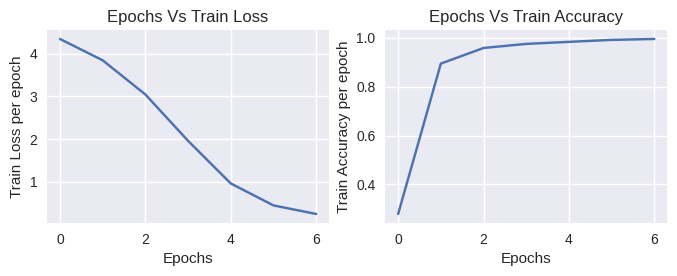

In [ ]:
tar=[tensor.cpu().numpy() for tensor in tar]
visualize_plots(7,train_loss,train_accuracy,pred,tar)


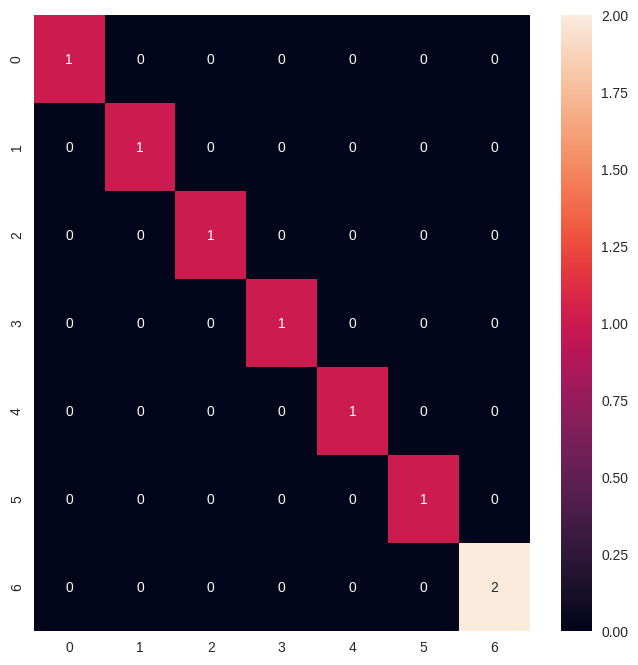

In [ ]:
confusion_matrix_plot(tar,pred)